In [1]:
from matplotlib import pyplot as plt
from keras.datasets import cifar10
import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.layers import BatchNormalization
import time
from keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, Input
import numpy as np
import pickle
from random import shuffle
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import cv2
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


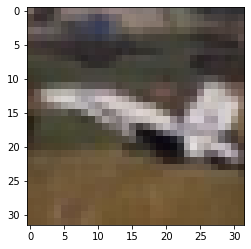

In [ ]:
index = random.randint(0, len(X_train))
plt.imshow(X_train[index])
plt.show()

In [ ]:
img_width = 32
img_height = 32

In [ ]:
def reshape(X, img_width, img_height):
    X = np.array(X).reshape(-1, img_height, img_width, 3)
    X = np.array(X).astype('float') / 255.0
    return X

X_train = reshape(X_train, img_width, img_height)
X_test = reshape(X_test, img_width, img_height)

In [ ]:
y_train = to_categorical(y_train, dtype ="uint8")
y_test = to_categorical(y_test, dtype ="uint8")

In [ ]:
print(f'Training Samples: {X_train.shape[0]}')
print(f'Testing Samples: {X_test.shape[0]}')

Training Samples: 50000
Testing Samples: 10000


In [ ]:
init_model = Sequential()
init_model.add(Conv2D(16, kernel_size=3, input_shape=(img_width, img_height, 3), activation='relu'))
init_model.add(Conv2D(32, (3, 3), activation='relu'))
init_model.add(MaxPooling2D(pool_size=(2, 2)))
init_model.add(Conv2D(64, (3, 3), activation='relu'))
init_model.add(Conv2D(128, (3, 3), activation='relu'))
init_model.add(MaxPooling2D(pool_size=(2, 2)))
init_model.add(Flatten())
init_model.add(Dense(256, activation='relu'))
init_model.add(Dropout(0.4))
init_model.add(Dense(10, activation='softmax'))
init_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
init_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                    

In [ ]:
history = init_model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=132
)

Epoch 1/50
341/341 [==============================] - 13s 12ms/step - loss: 1.6512 - accuracy: 0.3928 - val_loss: 1.3458 - val_accuracy: 0.5096
Epoch 2/50
341/341 [==============================] - 4s 11ms/step - loss: 1.2791 - accuracy: 0.5447 - val_loss: 1.1439 - val_accuracy: 0.5946
Epoch 3/50
341/341 [==============================] - 3s 10ms/step - loss: 1.0964 - accuracy: 0.6140 - val_loss: 0.9941 - val_accuracy: 0.6564
Epoch 4/50
341/341 [==============================] - 4s 11ms/step - loss: 0.9663 - accuracy: 0.6615 - val_loss: 0.8766 - val_accuracy: 0.6930
Epoch 5/50
341/341 [==============================] - 4s 11ms/step - loss: 0.8761 - accuracy: 0.6921 - val_loss: 0.8345 - val_accuracy: 0.7112
Epoch 6/50
341/341 [==============================] - 4s 11ms/step - loss: 0.7873 - accuracy: 0.7250 - val_loss: 0.8189 - val_accuracy: 0.7208
Epoch 7/50
341/341 [==============================] - 4s 11ms/step - loss: 0.7266 - accuracy: 0.7465 - val_loss: 0.7572 - val_accuracy: 0.743

In [ ]:
def plot_validation_training_curves(history):  
  plt.figure(figsize=(30, 30))

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.subplot(4, 4, 1)
  plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
  plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
  plt.title('Training vs Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.subplot(4, 4, 2)
  plt.plot(epochs, loss, color='red', label='Trainig loss')
  plt.plot(epochs, val_loss, color='green', label='Validation Loss')
  plt.title('Training vs Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

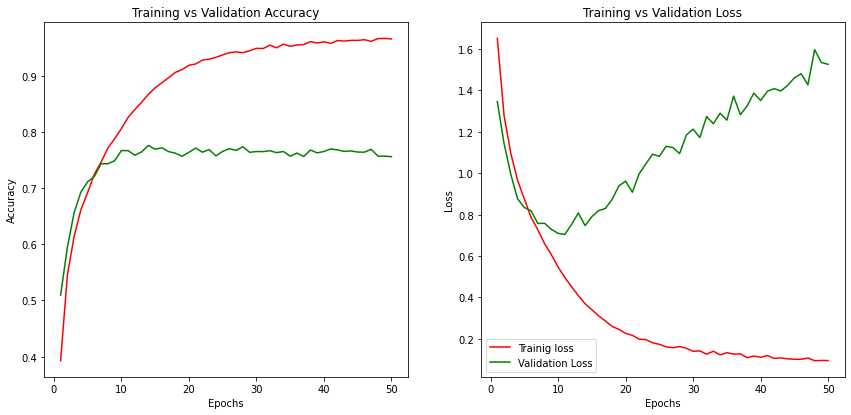

In [ ]:
plot_validation_training_curves(history)

# It seems that the overfitting seems to occur right after the 9th epoch.

In [ ]:
# Evaluating the model and saving the result:
_, init_acc = init_model.evaluate(X_test, y_test, verbose=0)
init_acc = round(init_acc, 2)
print(f'Test Set Accuracy: {init_acc}')


with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/init_acc.pkl', 'wb') as f:
  pickle.dump(init_acc, f)

Test Set Accuracy: 0.74


In [4]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/init_acc.pkl', 'rb') as f:
  init_acc = pickle.load(f)

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=3, input_shape=(img_width, img_height, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=9,
    batch_size=132
)

Epoch 1/9
341/341 [==============================] - 6s 15ms/step - loss: 1.6644 - accuracy: 0.3892 - val_loss: 1.3525 - val_accuracy: 0.5056
Epoch 2/9
341/341 [==============================] - 4s 11ms/step - loss: 1.2800 - accuracy: 0.5438 - val_loss: 1.1423 - val_accuracy: 0.5996
Epoch 3/9
341/341 [==============================] - 4s 11ms/step - loss: 1.0944 - accuracy: 0.6156 - val_loss: 1.0320 - val_accuracy: 0.6318
Epoch 4/9
341/341 [==============================] - 4s 10ms/step - loss: 0.9614 - accuracy: 0.6616 - val_loss: 0.8919 - val_accuracy: 0.6918
Epoch 5/9
341/341 [==============================] - 4s 13ms/step - loss: 0.8614 - accuracy: 0.6989 - val_loss: 0.8151 - val_accuracy: 0.7224
Epoch 6/9
341/341 [==============================] - 4s 10ms/step - loss: 0.7843 - accuracy: 0.7250 - val_loss: 0.7774 - val_accuracy: 0.7306
Epoch 7/9
341/341 [==============================] - 4s 11ms/step - loss: 0.7058 - accuracy: 0.7517 - val_loss: 0.7634 - val_accuracy: 0.7370
Epoch 

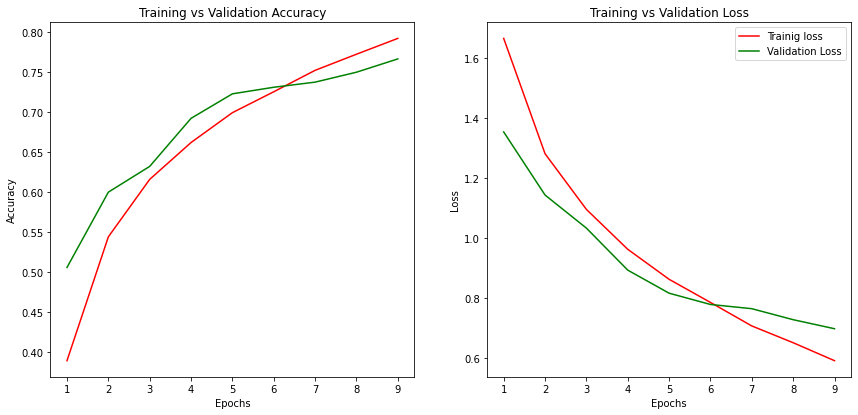

In [ ]:
plot_validation_training_curves(history)

In [ ]:
_, revised_init_acc = model.evaluate(X_test, y_test, verbose=0)
revised_init_acc = round(revised_init_acc, 2)
print(f'Test Set Accuracy: {revised_init_acc}')

with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/revised_init_acc.pkl', 'wb') as f:
  pickle.dump(revised_init_acc, f)

Test Set Accuracy: 0.75


In [5]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/revised_init_acc.pkl', 'rb') as f:
  revised_init_acc = pickle.load(f)

# **Image Augmentation**

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

data_gen.fit(X_train)

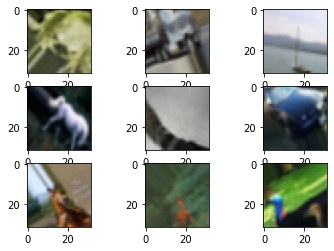

In [ ]:
# Following are some of the examples of augmented images:

for X_batch, y_batch in data_gen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [ ]:
X_train = X_train.astype("float32")  
X_test = X_test.astype("float32")
mean = np.mean(X_train)
std = np.std(X_train)
X_test = (X_test - mean) / std
X_train = (X_train - mean) / std

In [ ]:
y_train = to_categorical(y_train, dtype ="uint8")
y_test = to_categorical(y_test, dtype ="uint8")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1)

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=3, input_shape=(img_width, img_height, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=128),
    steps_per_epoch=(len(X_train) // 128),
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50
351/351 [==============================] - 24s 66ms/step - loss: 1.8515 - accuracy: 0.3127 - val_loss: 1.4674 - val_accuracy: 0.4544
Epoch 2/50
351/351 [==============================] - 24s 68ms/step - loss: 1.5910 - accuracy: 0.4199 - val_loss: 1.3944 - val_accuracy: 0.4964
Epoch 3/50
351/351 [==============================] - 25s 71ms/step - loss: 1.4480 - accuracy: 0.4798 - val_loss: 1.2622 - val_accuracy: 0.5438
Epoch 4/50
351/351 [==============================] - 24s 67ms/step - loss: 1.3705 - accuracy: 0.5099 - val_loss: 1.2331 - val_accuracy: 0.5606
Epoch 5/50
351/351 [==============================] - 23s 67ms/step - loss: 1.3008 - accuracy: 0.5369 - val_loss: 1.2214 - val_accuracy: 0.5610
Epoch 6/50
351/351 [==============================] - 24s 67ms/step - loss: 1.2515 - accuracy: 0.5551 - val_loss: 1.0279 - val_accuracy: 0.6204
Epoch 7/50
351/351 [==============================] - 24s 67ms/step - loss: 1.2152 - accuracy: 0.5710 - val_loss: 0.9943 - val_accuracy:

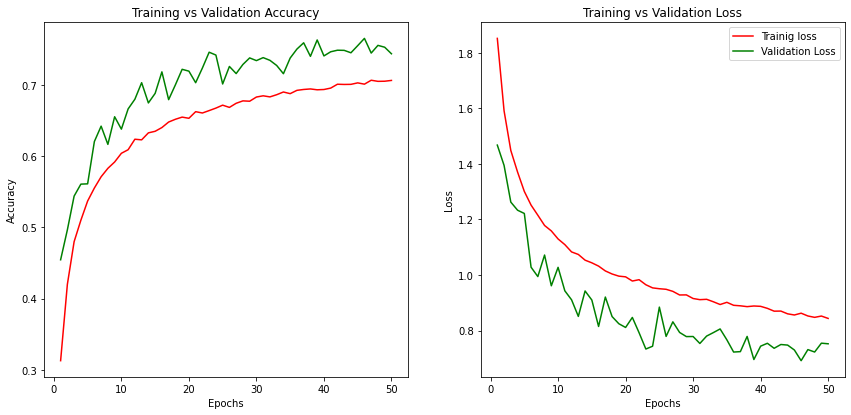

In [ ]:
plot_validation_training_curves(history)

# The model doesn't seem to overfit, rather the validation accuracy seems to be higher than training accuracy at each epoch.

In [ ]:
_, aug_acc = model.evaluate(X_test, y_test, verbose=0)
aug_acc = round(aug_acc, 2)
print(f'Test Set Accuracy After Augmentation: {aug_acc}')

Test Set Accuracy After Augmentation: 0.74


In [ ]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/aug_acc.pkl', 'wb') as f:
  pickle.dump(aug_acc, f)

In [6]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/aug_acc.pkl', 'rb') as f:
  aug_acc = pickle.load(f)

# **VGG16**

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
y_train = to_categorical(y_train, dtype ="uint8")
y_test = to_categorical(y_test, dtype ="uint8")

In [ ]:
import keras
conv_base = keras.applications.vgg16.VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=(img_width, img_height, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
X_train_vgg_output = conv_base.predict(X_train, verbose=1)
X_test_vgg_output = conv_base.predict(X_test, verbose=1)

313/313 [==============================] - 2s 8ms/step


In [ ]:
print(X_train_vgg_output.shape)
print(X_test_vgg_output.shape)

(50000, 1, 1, 512)
(10000, 1, 1, 512)


In [ ]:
X_train = np.reshape(X_train_vgg_output, (50000, 1 * 1 * 512))
X_test = np.reshape(X_test_vgg_output, (10000, 1 * 1 * 512))

In [ ]:
print(X_train.shape)
print(X_test.shape)

(50000, 512)
(10000, 512)


In [ ]:
model = Sequential()
model.add(Dense(4096, activation='relu', input_dim=1 * 1 * 512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.1)

Epoch 1/50
352/352 [==============================] - 4s 10ms/step - loss: 1.7569 - accuracy: 0.5142 - val_loss: 1.3395 - val_accuracy: 0.5968
Epoch 2/50
352/352 [==============================] - 3s 9ms/step - loss: 1.2617 - accuracy: 0.6016 - val_loss: 1.2750 - val_accuracy: 0.5936
Epoch 3/50
352/352 [==============================] - 3s 10ms/step - loss: 1.1393 - accuracy: 0.6346 - val_loss: 1.2123 - val_accuracy: 0.6138
Epoch 4/50
352/352 [==============================] - 3s 9ms/step - loss: 1.0356 - accuracy: 0.6629 - val_loss: 1.2593 - val_accuracy: 0.6232
Epoch 5/50
352/352 [==============================] - 3s 9ms/step - loss: 0.9533 - accuracy: 0.6859 - val_loss: 1.2036 - val_accuracy: 0.6340
Epoch 6/50
352/352 [==============================] - 4s 11ms/step - loss: 0.8873 - accuracy: 0.7056 - val_loss: 1.2716 - val_accuracy: 0.6284
Epoch 7/50
352/352 [==============================] - 4s 12ms/step - loss: 0.8076 - accuracy: 0.7300 - val_loss: 1.3424 - val_accuracy: 0.6216
Ep

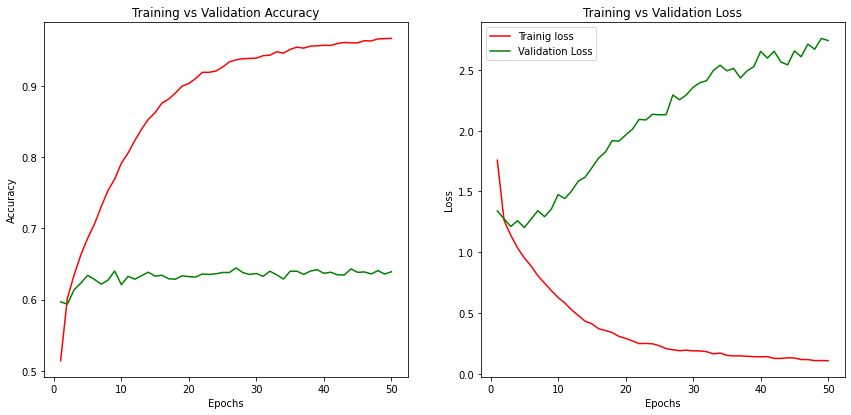

In [ ]:
plot_validation_training_curves(history)

# The overfitting seems to start after the 3rd epoch. Let us retrain the model for 3 epochs

In [ ]:
_, vgg_acc = model.evaluate(X_test, y_test, verbose=0)
vgg_acc = round(vgg_acc, 2)
print(f'Test Accuracy VGG16: {vgg_acc}')


with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/vgg_acc.pkl', 'wb') as f:
  pickle.dump(vgg_acc, f)

Test Accuracy VGG16: 0.64


In [7]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/vgg_acc.pkl', 'rb') as f:
  vgg_acc = pickle.load(f)

In [ ]:
model = Sequential()
model.add(Dense(4096, activation='relu', input_dim=1 * 1 * 512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.1)

Epoch 1/3
352/352 [==============================] - 5s 11ms/step - loss: 1.7531 - accuracy: 0.5149 - val_loss: 1.5869 - val_accuracy: 0.5526
Epoch 2/3
352/352 [==============================] - 3s 10ms/step - loss: 1.2661 - accuracy: 0.5971 - val_loss: 1.2948 - val_accuracy: 0.5950
Epoch 3/3
352/352 [==============================] - 3s 10ms/step - loss: 1.1267 - accuracy: 0.6333 - val_loss: 1.2884 - val_accuracy: 0.6198


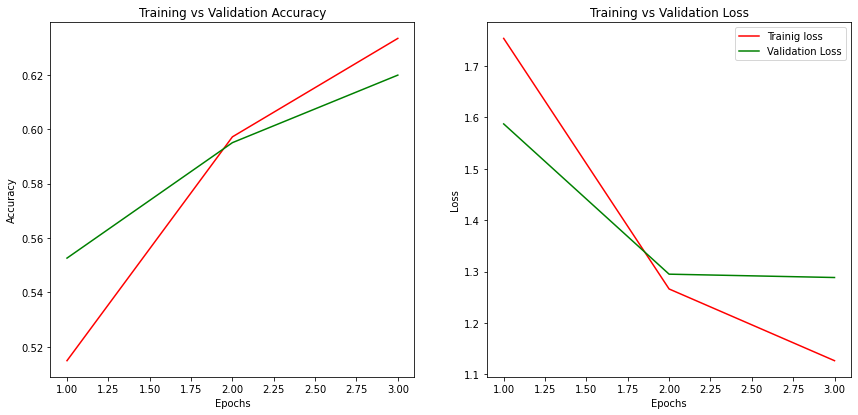

In [ ]:
plot_validation_training_curves(history)

In [ ]:
_, rev_vgg_acc = model.evaluate(X_test, y_test, verbose=0)
rev_vgg_acc = round(rev_vgg_acc, 2)
print(f'Test Accuracy of Revised VGG16: {rev_vgg_acc}')

Test Accuracy of Revised VGG16: 0.62


In [ ]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/revised_vgg_acc.pkl', 'wb') as f:
  pickle.dump(rev_vgg_acc, f)

In [8]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/revised_vgg_acc.pkl', 'rb') as f:
  rev_vgg_acc = pickle.load(f)

# **Fine-tuning VGG16 (Unfreezing last two layers)**

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
X_train = np.array([cv2.resize(x, (48, 48), interpolation=cv2.INTER_AREA) for x in X_train])
X_test = np.array([cv2.resize(x, (48, 48), interpolation=cv2.INTER_AREA) for x in X_test])

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
X_train = np.reshape(X_train, (-1, 48, 48, 3))
X_test = np.reshape(X_test, (-1, 48, 48, 3))

In [ ]:
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(48, 48, 3))
inp = Input(shape=(48, 48, 3))

x = vgg16_model.layers[0](inp)
vgg16_model.layers[0].trainable = False

for layer in vgg16_model.layers[1:]:
  if i in (17, 18):
      layer.trainable = True
  else:
      layer.trainable = False
  x = layer(x)

# Add the fully-connected layers at the end
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', name='predictions')(x)

model = Model(inputs=inp, outputs=x)

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 input_22 (InputLayer)       multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       1475

In [ ]:
optimizer = Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, validation_split=0.1, batch_size=64, epochs=50, verbose=1)

Epoch 1/50
704/704 [==============================] - 63s 68ms/step - loss: 2.4215 - accuracy: 0.1782 - val_loss: 2.0879 - val_accuracy: 0.2052
Epoch 2/50
704/704 [==============================] - 47s 67ms/step - loss: 2.1304 - accuracy: 0.2025 - val_loss: 2.4855 - val_accuracy: 0.2144
Epoch 3/50
704/704 [==============================] - 47s 67ms/step - loss: 2.0207 - accuracy: 0.2436 - val_loss: 2.0672 - val_accuracy: 0.2812
Epoch 4/50
704/704 [==============================] - 47s 67ms/step - loss: 1.7872 - accuracy: 0.3196 - val_loss: 1.6112 - val_accuracy: 0.3620
Epoch 5/50
704/704 [==============================] - 48s 69ms/step - loss: 1.5431 - accuracy: 0.4148 - val_loss: 1290.9713 - val_accuracy: 0.4924
Epoch 6/50
704/704 [==============================] - 47s 67ms/step - loss: 1.3317 - accuracy: 0.5066 - val_loss: 1.5315 - val_accuracy: 0.5054
Epoch 7/50
704/704 [==============================] - 48s 69ms/step - loss: 1.1652 - accuracy: 0.5796 - val_loss: 1.5409 - val_accura

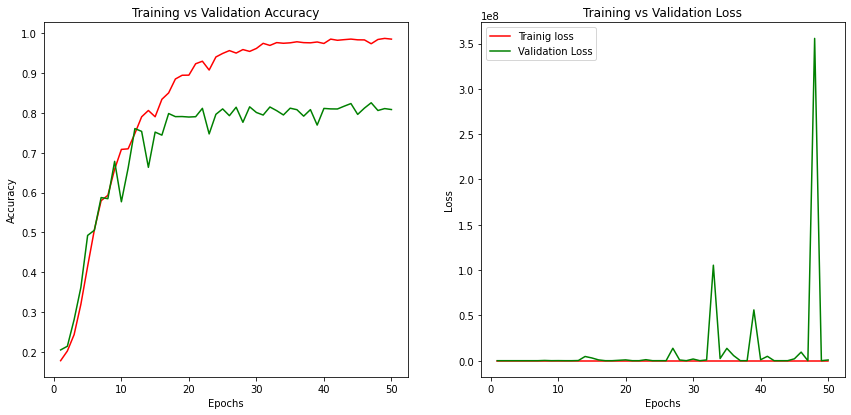

In [ ]:
plot_validation_training_curves(history)

# The model starts to highly overfit after around 16th epoch, let us retrain it for 16epochs only 

In [ ]:
_, fine_vgg_acc = model.evaluate(X_test, y_test, verbose=0)
print("Fine-tuned VGG16 Accuracy on 50 Epochs: {0}".format(fine_vgg_acc))

Fine-tuned VGG16 Accuracy on 50 Epochs: 0.8051000237464905


In [ ]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/fine_vgg_acc-50epochs.pkl', 'wb') as f:
  pickle.dump(fine_vgg_acc, f)

In [9]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/fine_vgg_acc-50epochs.pkl', 'rb') as f:
  fine_vgg_acc = pickle.load(f)

In [ ]:
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(48, 48, 3))
inp = Input(shape=(48, 48, 3))

x = vgg16_model.layers[0](inp)
vgg16_model.layers[0].trainable = False

for i, layer in enumerate(vgg16_model.layers[1:]):
  if i in (17, 18):
    layer.trainable = True
  else:
    layer.trainable = False
  x = layer(x)

# Add the fully-connected layers at the end
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', name='predictions')(x)

model = Model(inputs=inp, outputs=x)

optimizer = Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, validation_split=0.1, batch_size=64, epochs=16, verbose=1)

Epoch 1/16
704/704 [==============================] - 27s 37ms/step - loss: 1.6003 - accuracy: 0.4883 - val_loss: 31.6549 - val_accuracy: 0.2520
Epoch 2/16
704/704 [==============================] - 25s 36ms/step - loss: 1.0099 - accuracy: 0.6746 - val_loss: 9.4518 - val_accuracy: 0.3434
Epoch 3/16
704/704 [==============================] - 27s 38ms/step - loss: 0.9871 - accuracy: 0.6884 - val_loss: 2551.8247 - val_accuracy: 0.1038
Epoch 4/16
704/704 [==============================] - 29s 41ms/step - loss: 0.7962 - accuracy: 0.7458 - val_loss: 4.2192 - val_accuracy: 0.7448
Epoch 5/16
704/704 [==============================] - 27s 39ms/step - loss: 0.6861 - accuracy: 0.7791 - val_loss: 2.7161 - val_accuracy: 0.7500
Epoch 6/16
704/704 [==============================] - 26s 37ms/step - loss: 0.5756 - accuracy: 0.8109 - val_loss: 57.0056 - val_accuracy: 0.5560
Epoch 7/16
704/704 [==============================] - 27s 38ms/step - loss: 0.5172 - accuracy: 0.8306 - val_loss: 0.9430 - val_accu

In [ ]:
_, rev_fine_vgg_acc = model.evaluate(X_test, y_test, verbose=0)
rev_fine_vgg_acc = round(rev_fine_vgg_acc, 2)
print("Revised Fine-tuned VGG16 Accuracy: {0}".format(rev_fine_vgg_acc))

Revised Fine-tuned VGG16 Accuracy: 0.82


In [ ]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/rev_fine_vgg_acc.pkl', 'wb') as f:
  pickle.dump(rev_fine_vgg_acc, f)

In [10]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/rev_fine_vgg_acc.pkl', 'rb') as f:
  rev_fine_vgg_acc = pickle.load(f)

# **Fine Tuning VGG16 With Augmentation**

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
X_train = np.array([cv2.resize(x, (48, 48), interpolation=cv2.INTER_AREA) for x in X_train])
X_test = np.array([cv2.resize(x, (48, 48), interpolation=cv2.INTER_AREA) for x in X_test])

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

data_gen.fit(X_train)

In [ ]:
X_train = X_train.astype("float32")  
X_test = X_test.astype("float32")
mean = np.mean(X_train)
std = np.std(X_train)
X_test = (X_test - mean) / std
X_train = (X_train - mean) / std

In [ ]:
X_train = np.reshape(X_train, (-1, 48, 48, 3))
X_test = np.reshape(X_test, (-1, 48, 48, 3))

In [ ]:
y_train = to_categorical(y_train, dtype ="uint8")
y_test = to_categorical(y_test, dtype ="uint8")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1)

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(48, 48, 3))
inp = Input(shape=(48, 48, 3))

x = vgg16_model.layers[0](inp)
vgg16_model.layers[0].trainable = False

for i, layer in enumerate(vgg16_model.layers[1:]):
  if i in (17, 18):
      layer.trainable = True
  else:
      layer.trainable = False
  x = layer(x)

# Add the fully-connected layers at the end
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', name='predictions')(x)

model = Model(inputs=inp, outputs=x)

In [ ]:
optimizer = Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=(len(X_train) // 64),
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1
)

Epoch 1/50
703/703 [==============================] - 61s 85ms/step - loss: 1.8412 - accuracy: 0.4717 - val_loss: 1.5633 - val_accuracy: 0.5816
Epoch 2/50
703/703 [==============================] - 54s 76ms/step - loss: 1.4859 - accuracy: 0.5236 - val_loss: 1.2299 - val_accuracy: 0.6254
Epoch 3/50
703/703 [==============================] - 47s 67ms/step - loss: 1.3930 - accuracy: 0.5420 - val_loss: 1.1719 - val_accuracy: 0.6330
Epoch 4/50
703/703 [==============================] - 46s 66ms/step - loss: 1.3429 - accuracy: 0.5543 - val_loss: 1.1892 - val_accuracy: 0.6274
Epoch 5/50
703/703 [==============================] - 44s 63ms/step - loss: 1.2954 - accuracy: 0.5665 - val_loss: 1.0705 - val_accuracy: 0.6524
Epoch 6/50
703/703 [==============================] - 45s 63ms/step - loss: 1.2633 - accuracy: 0.5755 - val_loss: 1.0253 - val_accuracy: 0.6584
Epoch 7/50
703/703 [==============================] - 44s 62ms/step - loss: 1.2351 - accuracy: 0.5794 - val_loss: 1.0455 - val_accuracy:

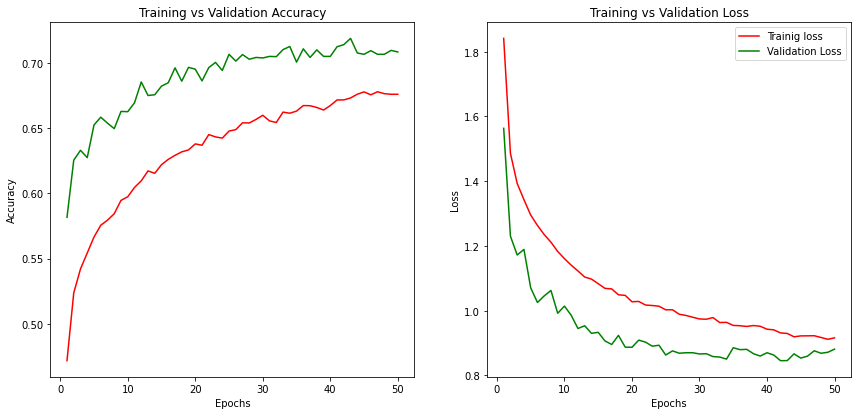

In [ ]:
plot_validation_training_curves(history)

In [ ]:
_, fine_vgg_aug_acc = model.evaluate(X_test, y_test, verbose=0)
fine_vgg_aug_acc = round(fine_vgg_aug_acc, 2)
print(f'Test Accuracy of Fine-tuned VGG16 with Augmentation: {fine_vgg_aug_acc}')


with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/fine_vgg_aug_acc.pkl', 'wb') as f:
  pickle.dump(fine_vgg_aug_acc, f)

Test Accuracy of Fine-tuned VGG16 with Augmentation: 0.7


In [11]:
with open('/content/drive/MyDrive/CIFAR10-multiclass-classification/fine_vgg_aug_acc.pkl', 'rb') as f:
  fine_vgg_aug_acc = pickle.load(f)

# **Summary and Conclusion**

It seems that on CIFAR10 dataset, the pre-trained VGG16 architecture, when fine-tuned, outperforms all other techniques we have employed in the assignment. This makes sense, since VGG16 is trained on imagenet and the samples of imagenet and cifar10 are more or less the similar with the exception of image size. Nonetheless, the maximum accuracy that I was achieve was around 82% with Fine-tuned VGG16. The results are summarized in the tabular form below.

In [18]:
import pandas as pd

def get_percentage(acc):
  return str(int(acc*100)) + '%'

results = pd.DataFrame(
    [['4-Conv-Layer Model', get_percentage(init_acc)],
     ['4-Conv-Layer Model-Revised', get_percentage(revised_init_acc)],
     ['4-Conv-Layer Model With Augmentation', get_percentage(aug_acc)],
     ['VGG16', get_percentage(vgg_acc)],
     ['VGG16 Revised', get_percentage(rev_vgg_acc)],
     ['Fine-tuned VGG16', get_percentage(fine_vgg_acc)],
     ['Fine-tuned VGG16 Revised', get_percentage(rev_fine_vgg_acc)],
     ['Fine-tuned VGG16 With Augmentation', get_percentage(fine_vgg_aug_acc)]]
)

results.columns = ['Model', 'Accuracy']

results

,Model,Accuracy
0,4-Conv-Layer Model,74%
1,4-Conv-Layer Model-Revised,75%
2,4-Conv-Layer Model With Augmentation,74%
3,VGG16,64%
4,VGG16 Revised,62%
5,Fine-tuned VGG16,80%
6,Fine-tuned VGG16 Revised,82%
7,Fine-tuned VGG16 With Augmentation,70%
